构建ResNet-18残差神经网络

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim

构建ResBlock残差块

In [4]:
class ResBlock(nn.Module):
    def __init__(self,in_channel,out_channel,stride=1):
        super(ResBlock,self).__init__()
        # 定义残差块中的两个卷积层
        self.left=nn.Sequential(
            nn.Conv2d(in_channel,out_channel,kernel_size=3,padding=1,stride=stride,bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channel,out_channel,kernel_size=3,padding=1,stride=1,bias=False),
            nn.BatchNorm2d(out_channel)
        )
        # 定义残差块中的shortcut
        self.shortcut=nn.Sequential()
        if stride!=1 or out_channel!=in_channel:
            self.shortcut=nn.Sequential(
                nn.Conv2d(in_channel,out_channel,kernel_size=1,stride=stride,bias=False),
                nn.BatchNorm2d(out_channel)
            )
    def forward(self,x):
        out=self.left(x)
        out+=self.shortcut(x)
        out=F.relu(out)
        return out
    

搭建ResNet-18神经网络

In [5]:
class ResNet18(nn.Module):
    def __init__(self,ResBlock,numclasses=10):
        super(ResNet18,self).__init__()
        self.conv1=nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=64,kernel_size=3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.layer1 = nn.Sequential(ResBlock(64, 64, stride=1))
        self.layer2 = nn.Sequential(ResBlock(64, 64, stride=1))
        self.layer3 = nn.Sequential(ResBlock(64, 128, stride=2))
        self.layer4 = nn.Sequential(ResBlock(128, 128, stride=1))
        self.layer5 = nn.Sequential(ResBlock(128, 256, stride=2))
        self.layer6 = nn.Sequential(ResBlock(256, 256, stride=1))
        self.layer7 = nn.Sequential(ResBlock(256, 512, stride=2))
        self.layer8 = nn.Sequential(ResBlock(512, 512, stride=1))
        self.fc=nn.Linear(512,numclasses)
    def forward(self,x):
        out=self.conv1(x)
        out=self.layer1(out)
        out=self.layer2(out)
        out=self.layer3(out)
        out=self.layer4(out)
        out=self.layer5(out)
        out=self.layer6(out)
        out=self.layer7(out)
        out=self.layer8(out)
        out=F.avg_pool2d(out,4)
        out=out.view(out.size(0),-1)
        out=self.fc(out)
        return out


加载数据集

In [40]:
# 数据预处理
transform=transforms.Compose([transforms.ToTensor(),
                            transforms.Normalize((0.5,),(0.5,)),
                            transforms.RandomHorizontalFlip(p=0.5),
                            transforms.RandomVerticalFlip(p=0.5),
                            ])
# 加载数据训练集
trainset=torchvision.datasets.FashionMNIST(root='./DATASET',train=True,download=False,transform=transform)
trainload=torch.utils.data.DataLoader(trainset,shuffle=True,batch_size=100,num_workers=0)
# 加载测试数据集
testset=torchvision.datasets.FashionMNIST(root='./DATASET',train=False,download=False,transform=transform)
testload=torch.utils.data.DataLoader(testset,shuffle=True,batch_size=100,num_workers=0)

classes=('T-shirt/top', 'Trouser', 'Pullover', 'Dress','Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

In [32]:
# 数据获取迭代器
dataiter=iter(trainload)
imgs,labels=next(dataiter)

In [33]:
#查看输入数据的shape
print(imgs.shape)

torch.Size([100, 1, 28, 28])


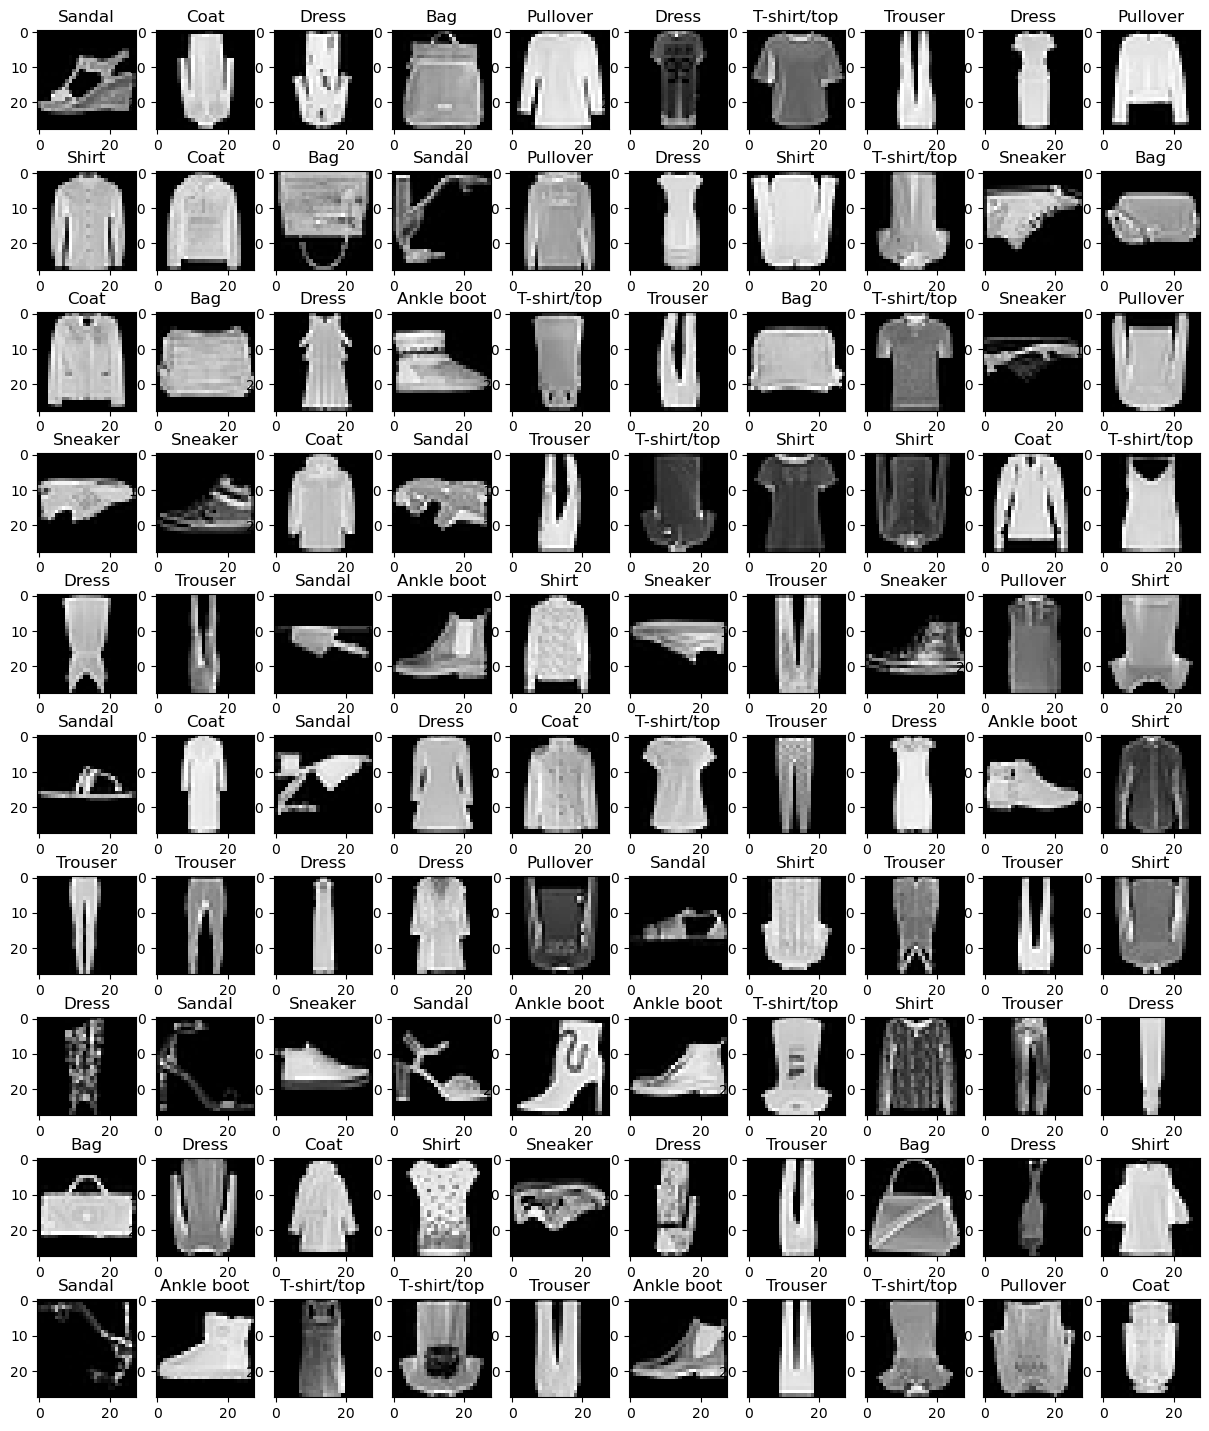

In [34]:
# 显示部分图像
row=10
column=10
pos=1
plt.figure(figsize=(15,18))
for i in range(row):
    for j in range(column):
        plt.subplot(row,column,pos)
        plt.imshow(imgs[pos-1].numpy().squeeze(),cmap='gray')
        plt.title(classes[labels[pos-1].item()])
        pos+=1

In [43]:
# 训练模型 
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# 构建网络
net=ResNet18(ResBlock)
net=net.to(device)
# 定义损失函数和优化器
loss_function=nn.CrossEntropyLoss()
optimizer=optim.Adam(net.parameters(),lr=0.001)
Epoch = 10
# 开始训练
for epoch in range(Epoch):
    running_loss=0
    correct=0
    total=0
    for i,data in enumerate(trainload,start=0):
        inputs,labels=data
        inputs,labels=inputs.to(device),labels.to(device)
        optimizer.zero_grad()
        outputs=net(inputs)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()

        _,predicted=torch.max(outputs.data,1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()

        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
    # 计算并打印每个 epoch 的正确率
    accuracy = 100 * correct / total
    print('Accuracy after epoch %d: %.2f%%' % (epoch + 1, accuracy))



[1,   100] loss: 0.791
[1,   200] loss: 0.502
[1,   300] loss: 0.448
[1,   400] loss: 0.403
[1,   500] loss: 0.366
[1,   600] loss: 0.373
Accuracy after epoch 1: 82.65%
[2,   100] loss: 0.337
[2,   200] loss: 0.321
[2,   300] loss: 0.326
[2,   400] loss: 0.316
[2,   500] loss: 0.307
[2,   600] loss: 0.305
Accuracy after epoch 2: 88.66%
[3,   100] loss: 0.277
[3,   200] loss: 0.285
[3,   300] loss: 0.273
[3,   400] loss: 0.275
[3,   500] loss: 0.273
[3,   600] loss: 0.259
Accuracy after epoch 3: 90.04%
[4,   100] loss: 0.255
[4,   200] loss: 0.255
[4,   300] loss: 0.242
[4,   400] loss: 0.261
[4,   500] loss: 0.244
[4,   600] loss: 0.243
Accuracy after epoch 4: 90.90%
[5,   100] loss: 0.225
[5,   200] loss: 0.235
[5,   300] loss: 0.231
[5,   400] loss: 0.233
[5,   500] loss: 0.238
[5,   600] loss: 0.242
Accuracy after epoch 5: 91.48%
[6,   100] loss: 0.216
[6,   200] loss: 0.213
[6,   300] loss: 0.209
[6,   400] loss: 0.234
[6,   500] loss: 0.211
[6,   600] loss: 0.216
Accuracy after ep

In [25]:
total_test=0
correct_test=0
with torch.no_grad():
    for data in testload:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        # torch.max(outputs.data, 1)返回outputs每一行中最大值的那个元素，且返回其索引
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
print(f'Accuracy of the network on the {total_test} test images: %d %%' % (100 * correct / total))

NameError: name 'testload' is not defined

In [24]:
#把predict_list转换为numpy
predicted = predicted.cpu()
preds = predicted.numpy()
images = images.cpu()
#打印部分预测结果
plt.figure(figsize=(15,18))
pos = 1
for i in range(row):
    for j in range(column):
        plt.subplot(row,column,pos)
        plt.imshow(images[pos-1].numpy().squeeze(),cmap='gray')
        plt.title(classes[preds[pos-1]])
        pos+=1

NameError: name 'predicted' is not defined

In [46]:
# 测试模型

net.eval()
correct = 0
total = 0
TN,TP,FN,FP=np.zeros(10),np.zeros(10),np.zeros(10),np.zeros(10)
# 不进行梯度计算，加快预测速度
with torch.no_grad():
    for data in testload:
        images, labels = data
        #print(images.shape)
        inputs = images
        inputs,labels=inputs.to(device),labels.to(device)
        outputs = net(inputs)
        #获取预测的类别
        _, predicted = torch.max(outputs.data, 1)
        
        '''
        Weight-average:对每类的评价指标进行加权求和,求得整个的评价指标
        计算每个类别的准确率、召回率、F1值
        然后对每个类别的评价指标进行加权求和，求得整个的评价指标
        TP:预测为正例的样本中，实际为正例的样本数
        FN:预测为负例的样本中,实际为正例的样本数
        FP:预测为正例的样本中,实际为负例的样本数
        TN:预测为负例的样本中,实际为负例的样本数
        '''
        TN += labels.shape[0];
        for i in range(predicted.shape[0]):
            #预测成功(预测为正例且实际为正例，或者预测为负例且实际为负例)
            if predicted[i] == labels[i]:
                #对于标签为predicted[i]的类别(TP)和其他类别(TN)来说都预测成功
                TP[predicted[i]]+=1
                TN[predicted[i]]-=1
            #预测失败（预测为正例但实际为负例，或者预测为负例而实际为正例）
            else:
                #对标签为predicted[i]的类别(FP),对于标签为labels[i]的类别(FN)
                FP[labels[i]]+=1
                FN[predicted[i]]+=1
                TN[labels[i]]-=1
                TN[predicted[i]]-=1
        
# 计算准确率，召回率，F1值
total=TP+FP+FN+TN
print('total:',total)  
accuracy = (TP + TN) / total
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * precision * recall / (precision + recall) 
weight=total/total.sum()
print(weight)
total_accuracy=np.sum(accuracy*weight)
total_precision=np.sum(precision*weight)
total_recall=np.sum(recall*weight)
total_f1=np.sum(f1*weight)
print('Accuracy: %.3f' % total_accuracy)
print('Precision: %.3f' % total_precision)
print('Recall: %.3f' % total_recall)
print('F1 score: %.3f' % total_f1)

total: [10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.]
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Accuracy: 0.985
Precision: 0.923
Recall: 0.924
F1 score: 0.923


In [82]:
# 保存模型
save_path = './ckpt/Resnet18' '.pth'
torch.save(net.state_dict(), save_path)

Shirt


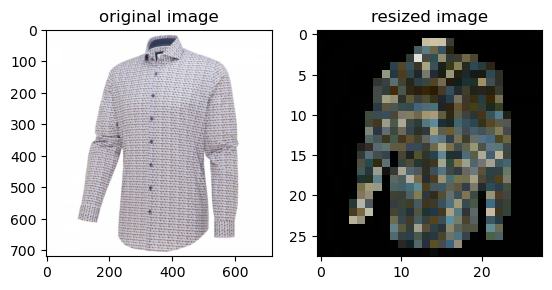

In [23]:
import cv2
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress','Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
#加载模型
path = './ckpt/Resnet18.pth'
model = ResNet(ResBlock)
model.load_state_dict(torch.load(path))
#预测图片
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
                                transforms.Resize((28,28)),
                                #转化为灰度图
                                transforms.Grayscale(num_output_channels=1)
                                ])
im = cv2.imread('./source/shirt.png')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
#预处理图片
resized_image = cv2.resize(im, (28, 28))
resized_image = 255 - resized_image
input = transform(im)  
#增加一个维度
input = input.unsqueeze(0)
# 把im转化为tensor
input = input.clone().detach().requires_grad_(True)
plt.subplot(1,2,1)
plt.imshow(im)
plt.title('original image')
plt.subplot(1,2,2)
plt.imshow(resized_image)
plt.title('resized image')

with torch.no_grad():
    outputs = model(input)
    _, predict = torch.max(outputs.data, 1) # 索引即classed中的类别
print(classes[predict])